In [1]:
import os
os.chdir(os.environ['PROJECT_DIR'])

import numpy as np
import pandas as pd
from pprint import pprint
import matplotlib.pyplot as plt

plt.style.use("classic")

from sklearn.manifold import TSNE

# import helpers for outlier detection
from od.helpers import *

In [2]:
# load metadata
sen_metadata = pd.read_csv("data/raw/sen_metadata.csv")
sen_statements = pd.read_csv("data/processed/sen_statements.csv")

# load feature sets
tfidf_vectors = np.load("data/vectorized/sen_statements/id=ALL/tfidf_vectors.npy")
doc2vec_vectors = np.load("data/vectorized/sen_statements/id=ALL/doc2vec_vectors.npy")
bert_vectors = np.load("data/vectorized/sen_statements/id=ALL/bert_vectors.npy")

# Dataset Exploration

### Democrat vs Republican vs Independent Visualization

In [3]:
member_to_party = dict(zip(sen_metadata['member_id'], sen_metadata['party']))
member_to_name = dict(zip(sen_metadata['member_id'], sen_metadata['name']))
party_to_color = {'D': 'blue', 'R': 'red', 'ID': 'green', 'I': 'green'}

In [4]:
plot_sample = sen_statements.sample(frac=.10, random_state=2021)
plot_sample_idxs = plot_sample.index.to_list()
bert_vectors_sample = bert_vectors.take(plot_sample_idxs, axis=0)

In [5]:
bert_vectors_tsne = TSNE(n_components=2, learning_rate='auto', init='pca', perplexity=100).fit_transform(bert_vectors_sample)

/Users/chasemattingly/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


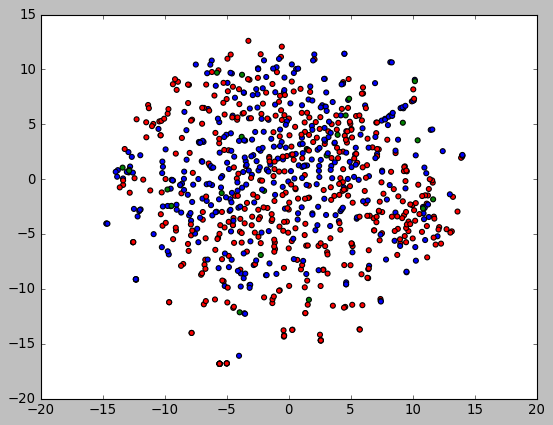

In [6]:
plt.scatter(bert_vectors_tsne[:, 0], 
            bert_vectors_tsne[:, 1], 
            c=plot_sample['member_id'].apply(lambda x: party_to_color[member_to_party[x]]))

```
We can see from the visualization above that the BERT document embeddings, the embeddings with the most semantic meaning, are not easily distinguishable between parties.
Therefore, in order to get a more meaningful visualization, I believe that the document topic embeddings will possibly give us more information to distingush content being discussed between parties.
```

### Dust and Magnet Topic Modeling Visualization

You can find the visualization on our research lab website [here](https://outliers.das-lab.org)

### Senators with least amount of statements

<AxesSubplot:>

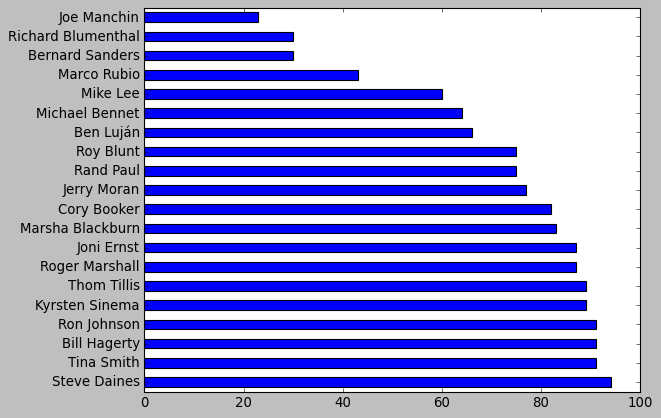

In [7]:
(sen_statements['member_id']
    .apply(lambda x: member_to_name[x])
    .value_counts()[-20:]
    .plot(kind='barh')
)

# Outlier Detection

```
We will be using the best methods for outlier detection we found with our toy dataset in the other notebook. 
The methods we have chosen are Normalized Cosine Similarity for Outlier Detection (NCSOD) and Copula-Based Outlier Detection (COPOD) with BERT document embeddings.
```

In [8]:
def k_lowest_idxs(scores, k=20):
    return np.argpartition(scores, k)[:k]

def k_highest_idxs(scores, k=20):
    return np.argsort(scores)[-k:]

## Finding Miscraped or Useless Documents
```
We can see from the absolute lowest scores that we have documents that weren't scraped properly. For example, documents with the www.ernst.senate.gov url from senator Joni Ernst lead to a query of documents instead of a singular document. That is why we see documents with the text "december december december...." -- representing the dates of each document.
```

### Cosine Similarity for Outlier Detection (CSOD)

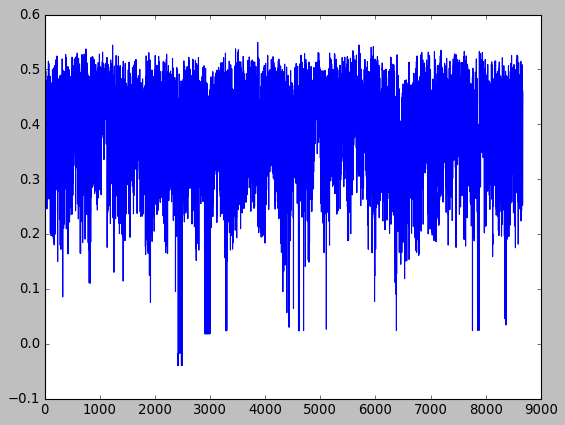

In [9]:
# lower the score lower the similarity with other vectors 
# good to see our outlier detection method is very fast on 8k+ documents
csod_scores = test_outliers([bert_vectors], csod)[0]

In [10]:
csod_outliers = sen_statements.loc[k_lowest_idxs(csod_scores, k=200)]

### Copula-Based Outlier Detection (COPOD) 

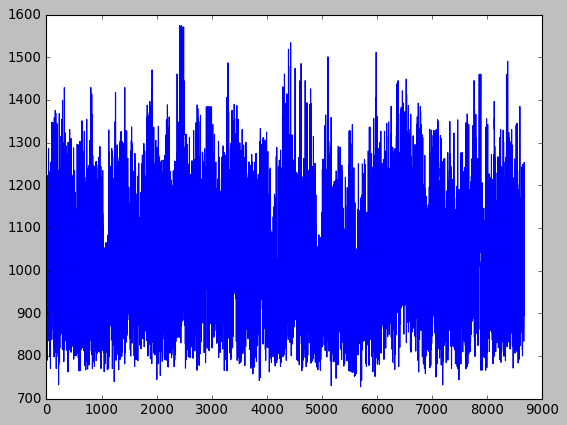

In [11]:
copod_scores = test_outliers([bert_vectors], copod)[0]

In [12]:
copod_outliers = sen_statements.loc[k_highest_idxs(copod_scores, k=200)]

In [13]:
csod_outliers

,member_id,title,date,url,text
2415,E000295,Tax Dollars Meant for COVID Relief Went Toward...,2022-04-04,http://www.ernst.senate.gov//public/index.cfm/...,december december december december december d...
2980,G000386,"Grassley, Bennet Seek Update on Their Effort t...",2022-04-29,https://www.grassley.senate.gov/news/news-rele...,nav mobile modalsearch mobile modal
2979,G000386,"Grassley, Johnson Demand Records from DoD Rese...",2022-04-29,https://www.grassley.senate.gov/news/news-rele...,nav mobile modalsearch mobile modal
2978,G000386,Grassley Seeks Update from HHS Inspector Gener...,2022-05-02,https://www.grassley.senate.gov/news/news-rele...,nav mobile modalsearch mobile modal
2977,G000386,Capitol Hill Report,2022-05-02,https://www.grassley.senate.gov/news/news-rele...,nav mobile modalsearch mobile modal
...,...,...,...,...,...
1254,C001070,Casey Announces $7.25 Million for Wilkes-Barre...,2022-08-26,https://www.casey.senate.gov/news/releases/cas...,funding extend taxiwaywith funding wilkes barr...
324,B001243,Senator Blackburn Wishes Tennessee A Merry Chr...,2021-12-23,https://www.blackburn.senate.gov/2021/12/senat...,nashville tenn marsha blackburn tenn wishes te...
4336,L000174,Statement On The Arrest Of Former Honduran Pol...,2022-03-10,https://www.leahy.senate.gov/press/statement-o...,for years urged successive administrations cut...
1253,C001070,Casey Announces $8.59 Million for University P...,2022-08-26,https://www.casey.senate.gov/news/releases/cas...,funding rehabilitate taxiwaywith funding unive...


#### Remove Useless Documents from corpus

In [14]:
# we can then drop k amount of documents that we see fit to remove outliers from the scraping
# we can also remove outliers that fall above a certain score
sen_statements = sen_statements.drop(index=csod_outliers.index)

In [15]:
sen_statements

,member_id,title,date,url,text
0,B001230,Baldwin Introduces Legislation to Improve Frei...,2022-09-27,https://www.baldwin.senate.gov/news/press-rele...,baldwin reliable rail service act help america...
1,B001230,Senator Baldwin Calls on USCIS to Address Back...,2022-09-27,https://www.baldwin.senate.gov/news/press-rele...,washington tammy baldwin sent letter today urg...
2,B001230,Senator Baldwin Works to Bring First Minority ...,2022-09-23,https://www.baldwin.senate.gov/news/press-rele...,department commerce awards north central minor...
3,B001230,"Senator Baldwin, Bipartisan Group Introduce Le...",2022-09-22,https://www.baldwin.senate.gov/news/press-rele...,washington today tammy baldwin joined bipartis...
4,B001230,"Senators Baldwin, Collins Introduce Bipartisan...",2022-09-22,https://www.baldwin.senate.gov/news/press-rele...,washington today tammy baldwin joined susan co...
...,...,...,...,...,...
8668,Y000064,ICYMI: Young Highlights Wasteful Spending in P...,2021-03-03,https://www.young.senate.gov/newsroom/press-re...,washington yesterday todd young ind laid oppos...
8669,Y000064,"Young, Braun introduce resolution honoring 100...",2021-03-02,https://www.young.senate.gov/newsroom/press-re...,washington today todd young ind mike braun ind...
8670,Y000064,"Young, Coons Resolution Establishing National ...",2021-03-02,https://www.young.senate.gov/newsroom/press-re...,washington todd young ind chris coons del intr...
8671,Y000064,Bipartisan Group of Senators Call on Houthis t...,2021-02-26,https://www.young.senate.gov/newsroom/press-re...,washington todd young ind chris murphy conn jo...


In [16]:
len(sen_statements.index)

8473

## Single Senator Analysis - ID=B001230 (Tammy Baldwin)

In [17]:
bert_vectors_tammy = np.load("data/vectorized/sen_statements/id=B001230/bert_vectors.npy")

### CSOD

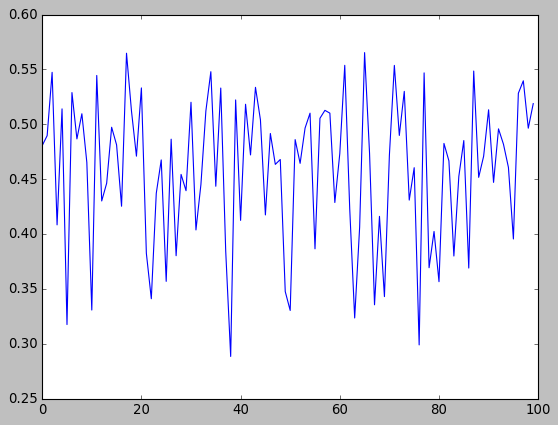

In [18]:
csod_scores_tammy = test_outliers([bert_vectors_tammy], csod)[0]

In [19]:
csod_outliers_tammy = sen_statements.loc[k_lowest_idxs(csod_scores_tammy, k=2)]

In [20]:
pprint(csod_outliers_tammy['text'].to_dict())

{38: 'chips science act boosts american semiconductor manufacturing '
     'strengthens supply chains creates good paying jobswashington tammy '
     'baldwin voted pass chips science act bipartisan legislation passed '
     'manufacturers wisconsin supporting bipartisan legislation boost domestic '
     'production semiconductor chips know essential moving economy forward '
     'voted legislation support wisconsin manufacturing strengthen domestic '
     'supply chain help lower costs businesses consumers it simple—we need '
     'america chips better support wisconsin manufacturing economy said '
     'baldwin wisconsin strong potential growth center world class research '
     'universities wisconsin manufacturing workforce knows products leaders '
     'bioenergy research water technology wisconsin positioned growth emerging '
     'industries passing legislation help support stem education providing '
     'create job growth state the chips science act',
 76: 'baldwin we forget d

### COPOD

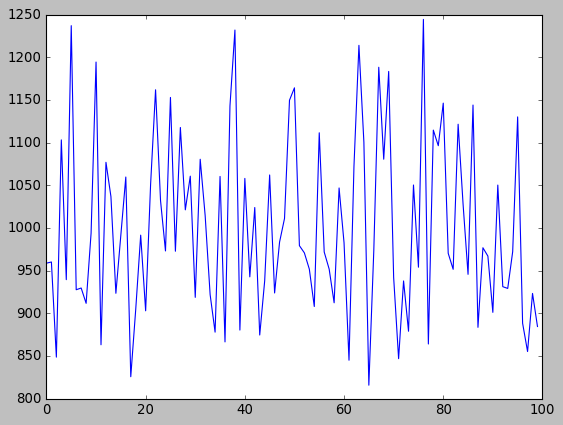

In [21]:
copod_scores_tammy = test_outliers([bert_vectors_tammy], copod)[0]

In [22]:
copod_outliers_tammy = sen_statements.loc[k_highest_idxs(copod_scores_tammy, k=3)]

In [23]:
pprint(copod_outliers_tammy['text'].to_dict())

{5: 'invent homeland security act applies buy america standards baldwin '
    'championed bipartisan infrastructure law inventions created federal '
    'researchwashington tammy baldwin rob portman introduced bipartisan invent '
    'homeland security act ensure products invented taxpayer funded research '
    'manufactured united states current law requires manufacturing products '
    'stemming federally funded research requirement routinely waived products '
    'manufactured overseas legislation require waivers issued accordance new '
    'buy america reporting requirements passed bipartisan infrastructure '
    'investment jobs act to simple american taxpayers funding research leads '
    'invention american manufacturers making products said baldwin building '
    'buy america standards championed bipartisan infrastructure legislation '
    'invent act create sustain good paying jobs home ensure high tech products '
    'america when government spends american taxpayer money inv

```
We can see we get a few apparent outliers, both methods introduce document 38 as a clear outlier. These documents discuss Tammy Badlwin passing a semiconductor manufacturing bill, which is highly related to the technological area. If we look at the different technology related acts / bills she has supported, we find that she hasn't mentioned supporting such bills since 2015/2016.

Nov 2, 2015 — Committee, today introduced legislation to help schools, districts, and states transform learning systems by utilizing innovative technology.
Mar 14, 2016 — WASHINGTON, D.C. – U.S. Senator Tammy Baldwin today introduced new legislation, the Water Technology Acceleration Act, ...
...
GAP
...
Nov 22, 2022 — Senator Baldwin, Bipartisan Group of Senators Tell Appropriators: America's Competitive Future Depends on Fully Funding CHIPS & Science Act.
```

# Future Work

```
1. Use custom scrapers for senators that don't have url results from ProPoublica Api
2. Get truth values for outliers from content analysis team
```